In [ ]:
import os
os.environ["WANDB_API_KEY"] = "00c5bcfd2b2fbe9bce38152923c98635448f8c6f"

In [ ]:
os.system('mkdir ../dataset') 
os.system('mkdir ../models')
os.system('wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt')
os.system('wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt')
os.system('wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt')
os.system('wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt')
os.system('wget -O ../models/r2l_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/r2l_gen.pt')
os.system('wget -O ../models/u2r_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/u2r_gen.pt')
os.system('wget -O ../models/dos_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/dos_gen.pt')
os.system('wget -O ../models/probe_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/probe_gen.pt')
os.system('wget -O ../models/normal_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/normal_gen.pt')

0

In [ ]:
os.system('pip install wandb -q')
os.system(f'wandb login {os.environ["WANDB_API_KEY"]}')
import wandb

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
#plt.style.use('grayscale')
from sklearn.metrics import precision_recall_curve,RocCurveDisplay
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing
import time

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(f'Using {device} as device')

Using cpu as device


In [ ]:
class Critic(nn.Module):
  def __init__(self, data_dim):
    super(Critic,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(111, data_dim),
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, data_dim):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Linear(96, data_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.gen(x)

In [ ]:
def visualize_synthetic_data(generated, original, title):
  generated = generated[np.random.randint(0,len(generated),41)]
  original = original.iloc[np.random.randint(0,len(original),41),:41][:41]

  fig, (original_ax, synthesized_ax) = plt.subplots(1,2,figsize=(12,12))
  original_ax.set_title(f'Original({title})')
  synthesized_ax.set_title(f'Synthetic({title})')
  _ = original_ax.imshow(original)
  _ = synthesized_ax.imshow(generated)

In [ ]:
def generate_data(generator, num_instances, z_dim):
  generator.eval()
  with torch.no_grad():
    out = generator(torch.randn(num_instances, z_dim).view(-1,1,z_dim))
    return out.detach().reshape(-1,41)[:num_instances]

In [ ]:
def create_dataloader(X, y, batch_size):
  if y:
    y = np.array(X['41'])
  else:
    y = torch.ones(size=(X.shape[0],))
  y = torch.tensor(y, dtype=torch.float).to(device)

  X = np.array(X.iloc[:,:-1])
  X = torch.tensor(X, dtype=torch.float).to(device)

  pt_train = TensorDataset(X,y)
  pt_train = DataLoader(pt_train, batch_size=batch_size)
  return pt_train

In [ ]:
def normalize_data(X):
  mms = MinMaxScaler()
  return mms.fit_transform(X)

In [ ]:
def visualize_train_loss(loss_1, labels, epochs, loss_2 = None):
  plt.figure(figsize=(10,4))
  plt.plot(loss_1, linewidth=2)
  if loss_2:
    plt.plot(loss_2, linewidth=2)
  plt.legend(labels)
  plt.ylabel("loss")
  _ = plt.xlabel(f"epochs ({epochs})")

## Preprocessing

In [ ]:
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [ ]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [ ]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.shape

(125973, 43)

In [ ]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
sub_classes = df.iloc[:,41].value_counts()

In [ ]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [ ]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']
normal = ['normal']

In [ ]:
pd.set_option('display.max_rows', None) # or 1000.
train_1 = df['1'].value_counts()
train_1.rename('Train', inplace=True)
test_1 = df2['1'].value_counts()
test_1.rename('Test', inplace=True)
cnct = pd.concat([train_1, test_1], axis = 1)
cnct

,Train,Test
tcp,102689,18880
udp,14993,2621
icmp,8291,1043


In [ ]:
train_2 = df['2'].value_counts()
train_2.rename('Train', inplace=True)
test_2 = df2['2'].value_counts()
test_2.rename('Test', inplace=True)
cnct = pd.concat([train_2, test_2], axis = 1)
cnct

,Train,Test
http,40338,7853.0
private,21853,4774.0
domain_u,9043,894.0
smtp,7313,934.0
ftp_data,6860,851.0
eco_i,4586,262.0
other,4359,838.0
ecr_i,3077,752.0
telnet,2353,1626.0
finger,1767,136.0


In [ ]:
train_3 = df['3'].value_counts()
train_3.rename('Train', inplace=True)
test_3 = df2['3'].value_counts()
test_3.rename('Test', inplace=True)
cnct = pd.concat([train_3, test_3], axis = 1)
cnct

,Train,Test
SF,74945,14875
S0,34851,2013
REJ,11233,3850
RSTR,2421,669
RSTO,1562,773
S1,365,21
SH,271,73
S2,127,15
RSTOS0,103,2
S3,49,249


In [ ]:
df_X = df.drop('41', axis=1)
le = LabelEncoder()
for i in df_X:
  if df_X[i].dtype=='object':
    le.fit(df_X[i])
    df_X[i] = le.transform(df_X[i])
    df2[i] = le.transform(df2[i])
df.iloc[:,:40] = df_X

In [ ]:
df.iloc[:,:40] = normalize_data(df.iloc[:,:40])
df2.iloc[:,:40] = normalize_data(df2.iloc[:,:40])

In [ ]:
u2r_attacks = df[df['41'].apply(lambda x: x in u2r)].copy()
r2l_attacks = df[df['41'].apply(lambda x: x in r2l)].copy()
dos_attacks = df[df['41'].apply(lambda x: x in dos)].copy()
probe_attacks = df[df['41'].apply(lambda x: x in probe)].copy()
normal_traffic = df[df['41'].apply(lambda x: x in normal)].copy()

df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [ ]:
df['41'].value_counts()

normal       67343
malicious    58630
Name: 41, dtype: int64

### Testing set value counts

In [ ]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [ ]:
#In case of multi-class classification
#df_Y = le.fit(df['41']).transform(df['41'])
#df.iloc[:,41] = df_Y
#df_Y = le.transform(df2['41'])
#df2.iloc[:,41] = df_Y

#In case of binary classification
df.iloc[:,41] = df['41'].map(lambda x: 0 if x=='normal' else 1)
df2.iloc[:,41] = df2['41'].map(lambda x: 0 if x=='normal' else 1)

X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']
X_test = torch.tensor(np.array(X_test), dtype=torch.float, device=device)

**Creating TensorDatasets**

In [ ]:
r2l_dataset = create_dataloader(r2l_attacks, None, batch_size = 64)
u2r_dataset = create_dataloader(u2r_attacks, None, batch_size = 64)
dos_dataset = create_dataloader(dos_attacks, None, batch_size = 64)
probe_dataset = create_dataloader(probe_attacks, None, batch_size = 64)
normal_dataset = create_dataloader(normal_traffic, None, batch_size = 64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
r2l_generator = Generator(100,41)
r2l_generator.load_state_dict(torch.load('../models/r2l_gen.pt'))
u2r_generator = Generator(100,41)
u2r_generator.load_state_dict(torch.load('../models/u2r_gen.pt'))
dos_generator = Generator(100,41)
dos_generator.load_state_dict(torch.load('../models/dos_gen.pt'))
probe_generator = Generator(100,41)
probe_generator.load_state_dict(torch.load('../models/probe_gen.pt'))
normal_generator = Generator(100,41)
normal_generator.load_state_dict(torch.load('../models/normal_gen.pt'))

<All keys matched successfully>

In [ ]:
r2l_attacks.shape, probe_attacks.shape

((995, 42), (11656, 42))

In [ ]:
sample_space = 40000
total_attacks = sample_space * 1
r2l_req = 0 if sample_space <= r2l_attacks.shape[0] else sample_space - r2l_attacks.shape[0]
probe_req = 0 if sample_space <= probe_attacks.shape[0] else sample_space - probe_attacks.shape[0]
dos_req = 0 if sample_space <= dos_attacks.shape[0] else sample_space - dos_attacks.shape[0]
u2r_req = 0 if sample_space <= u2r_attacks.shape[0] else sample_space - u2r_attacks.shape[0]
normal_req = 0 if total_attacks <= normal_traffic.shape[0] else total_attacks - normal_traffic.shape[0]

In [ ]:
r2l_generated = generate_data(generator=r2l_generator, num_instances=r2l_req, z_dim=100)
u2r_generated = generate_data(generator=u2r_generator, num_instances=u2r_req, z_dim=100)
dos_generated = generate_data(generator=dos_generator, num_instances=dos_req, z_dim=100)
probe_generated = generate_data(generator=probe_generator, num_instances=probe_req, z_dim=100)
normal_generated = generate_data(generator=normal_generator, num_instances=normal_req, z_dim=100)

In [ ]:
r2l_generated.shape

torch.Size([39005, 41])

In [ ]:
r2l_generated = pd.DataFrame(r2l_generated.detach().numpy())
u2r_generated = pd.DataFrame(u2r_generated.detach().numpy())
dos_generated = pd.DataFrame(dos_generated.detach().numpy())
probe_generated = pd.DataFrame(probe_generated.detach().numpy())
normal_generated = pd.DataFrame(normal_generated.detach().numpy())

In [ ]:
r2l_attacks.columns = [i for i in range(df.shape[1])]
r2l_attacks = r2l_attacks.append(r2l_generated)
u2r_attacks.columns = [i for i in range(df.shape[1])]
u2r_attacks = u2r_attacks.append(u2r_generated)
dos_attacks.columns = [i for i in range(df.shape[1])]
dos_attacks = dos_attacks.append(dos_generated)[:sample_space]
probe_attacks.columns = [i for i in range(df.shape[1])]
probe_attacks = probe_attacks.append(probe_generated)
normal_traffic.columns = [i for i in range(df.shape[1])]
normal_traffic = normal_traffic.append(normal_generated)[:sample_space]

In [ ]:
def create_stratified_dataset(x, sample_space):
  dataset = []

  x[0].iloc[:,41] = 1
  x[1].iloc[:,41] = 1
  x[2].iloc[:,41] = 1
  x[3].iloc[:,41] = 1

  x[0] = x[0].to_numpy()
  x[1] = x[1].to_numpy()
  x[2] = x[2].to_numpy()
  x[3] = x[3].to_numpy()
  x[4] = x[4].to_numpy()

  for i in range(sample_space):
    dataset.append(x[0][i])
    dataset.append(x[1][i])
    dataset.append(x[2][i])
    dataset.append(x[3][i])
    dataset.append(x[4][i])
    
  return pd.DataFrame(dataset, columns=[str(i) for i in range(42)])

In [ ]:
dataset = pd.concat([r2l_attacks, u2r_attacks, dos_attacks, probe_attacks], axis=0)
dataset.columns = [str(i) for i in range(len(dataset.columns))]
normal_traffic.columns = [str(i) for i in range(len(dataset.columns))]
dataset.iloc[:,41] = 1
normal_traffic.iloc[:,41] = 0
dataset.reset_index(inplace=True, drop=True)
dataset = pd.concat([dataset, normal_traffic])
dataset = dataset.sample(frac=1)
#dataset = create_stratified_dataset([r2l_attacks, u2r_attacks, dos_attacks, probe_attacks, normal_traffic], sample_space)

In [ ]:
r2l_attacks.shape,u2r_attacks.shape,dos_attacks.shape,probe_attacks.shape, normal_traffic.shape

((40000, 42), (40000, 42), (40000, 42), (40000, 42), (40000, 42))

In [ ]:
X = dataset.drop('41', axis=1).to_numpy()
y = dataset['41']

In [ ]:
print(f'{X.shape} final size') 
print(f'Following are the label counts\n{y.value_counts()}')

(200000, 41) final size
Following are the label counts
1    160000
0     40000
Name: 41, dtype: int64


In [ ]:
pt_x_train = torch.tensor(X, dtype=torch.float).to(device)
y = nn.functional.one_hot(torch.tensor(y.to_numpy(dtype='int')))
pt_y_train = y.float().to(device)
tensor_dataset = TensorDataset(pt_x_train, pt_y_train)

In [ ]:
pt_x_train.shape, pt_y_train.shape

(torch.Size([200000, 41]), torch.Size([200000, 2]))

## **MLP**



In [ ]:
class MLP(nn.Module):
  data_dim = 41
  def __init__(self):
      super(MLP, self).__init__()
      self.mlp = nn.Sequential(
          nn.Linear(self.data_dim, 80),
          nn.ReLU(),
          nn.BatchNorm1d(80)
      )
      '''self.cnn = nn.Sequential(
          nn.Conv1d(1,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Flatten(),
          nn.Linear(330, 24),
          nn.ReLU(),
      )'''

      self.clf = nn.Sequential(
          nn.Linear(80,2),
          nn.Sigmoid()
      )

  def forward(self, x):
      features = self.mlp(x)
      return self.clf(features)

  def transform(self, x):
      return self.cnn(x)

In [ ]:
def validation_accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
    lr_probs = model(X).detach().squeeze()
  preds = torch.argmax(lr_probs, dim=1).cpu()
  acc = accuracy_score(y, preds)
  model.train()
  return acc

In [ ]:
batch_sizes = [32, 64, 128, 256]
epochs_ = [25, 40, 55, 70]
learning_rates = [1e-3, 1e-2, 1e-1]

In [ ]:
start_time = time.time()

In [ ]:
grid_scores = []
iters = 0
#Creating a Grid Search
for epochs in epochs_:
  for lr in learning_rates:
    for batch_size in batch_sizes:
      #Model init
      pt_train = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
      mlp = MLP().to(device)
      criterion = nn.BCELoss()
      optimizer = torch.optim.SGD(mlp.parameters(), lr = lr)
      
      #Training Loop
      run = wandb.init(entity='ahsen', project='nids', name=f'MLP_GAN_{iters}', reinit=True)
      wandb.config["lr"] = lr
      wandb.config["batch_size"] = batch_size
      wandb.config["epochs"] = epochs
      wandb.config["group"] = "MLP_GAN"
      print('===============================================')
      print(f"Batch Size:{batch_size}\tEpochs:{epochs}\tLR:{lr}")
      num_epochs = epochs
      outputs = []
      losses = []
      for epoch in range(num_epochs):
          for instance, y in pt_train:
              output = mlp(instance)
              loss = criterion(output, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          losses.append(loss.item())
          acc = validation_accuracy(mlp, X_test, y_test)
          wandb.log({'loss':loss.item()})
          print('------------------------------------------------')
          print(f'Epoch:{epoch+1}  \tLoss:{loss.item():.4f}\t Acc: {acc:.4f}')

      print("*************************************************")
      print(f'Final Score for (B:{batch_size}, Ep:{epochs}, LR:{lr})')
      print(f'Acc: {acc:.4f}')
      #Save scores
      obj = {
        "config":{
          "learning_rate": lr,
          "epochs": epochs,
          "batch_size": batch_size,
          "acc": acc,
          },
        "weights": mlp.state_dict()
      }
      wandb.log({"acc" : acc})
      run.finish()
      grid_scores.append(obj)
      iters = iters + 1

wandb: Currently logged in as: ahsen (use `wandb login --relogin` to force relogin)


Batch Size:32	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.0554	 Acc: 0.7449
------------------------------------------------
Epoch:2  	Loss:0.0277	 Acc: 0.7464
------------------------------------------------
Epoch:3  	Loss:0.0190	 Acc: 0.7342
------------------------------------------------
Epoch:4  	Loss:0.0167	 Acc: 0.7376
------------------------------------------------
Epoch:5  	Loss:0.0151	 Acc: 0.7387
------------------------------------------------
Epoch:6  	Loss:0.0118	 Acc: 0.7412
------------------------------------------------
Epoch:7  	Loss:0.0118	 Acc: 0.7415
------------------------------------------------
Epoch:8  	Loss:0.0151	 Acc: 0.7397
------------------------------------------------
Epoch:9  	Loss:0.0133	 Acc: 0.7417
------------------------------------------------
Epoch:10  	Loss:0.0107	 Acc: 0.7441
------------------------------------------------
Epoch:11  	Loss:0.0102	 Acc: 0.7449
-----------------------------------------

acc,▁
loss,█▄▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.75834
loss,0.00733


Batch Size:64	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.1944	 Acc: 0.7294
------------------------------------------------
Epoch:2  	Loss:0.1404	 Acc: 0.7465
------------------------------------------------
Epoch:3  	Loss:0.1154	 Acc: 0.7466
------------------------------------------------
Epoch:4  	Loss:0.0973	 Acc: 0.7557
------------------------------------------------
Epoch:5  	Loss:0.0829	 Acc: 0.7689
------------------------------------------------
Epoch:6  	Loss:0.0718	 Acc: 0.7728
------------------------------------------------
Epoch:7  	Loss:0.0618	 Acc: 0.7778
------------------------------------------------
Epoch:8  	Loss:0.0545	 Acc: 0.7804
------------------------------------------------
Epoch:9  	Loss:0.0495	 Acc: 0.7822
------------------------------------------------
Epoch:10  	Loss:0.0451	 Acc: 0.7840
------------------------------------------------
Epoch:11  	Loss:0.0413	 Acc: 0.7885
-----------------------------------------

acc,▁
loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
acc,0.79955
loss,0.02102


Batch Size:128	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.3045	 Acc: 0.7547
------------------------------------------------
Epoch:2  	Loss:0.2064	 Acc: 0.7669
------------------------------------------------
Epoch:3  	Loss:0.1638	 Acc: 0.7655
------------------------------------------------
Epoch:4  	Loss:0.1410	 Acc: 0.7697
------------------------------------------------
Epoch:5  	Loss:0.1248	 Acc: 0.7730
------------------------------------------------
Epoch:6  	Loss:0.1141	 Acc: 0.7765
------------------------------------------------
Epoch:7  	Loss:0.1057	 Acc: 0.7787
------------------------------------------------
Epoch:8  	Loss:0.0968	 Acc: 0.7772
------------------------------------------------
Epoch:9  	Loss:0.0903	 Acc: 0.7798
------------------------------------------------
Epoch:10  	Loss:0.0824	 Acc: 0.7818
------------------------------------------------
Epoch:11  	Loss:0.0732	 Acc: 0.7821
----------------------------------------

acc,▁
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
acc,0.78455
loss,0.03974


Batch Size:256	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.3632	 Acc: 0.7340
------------------------------------------------
Epoch:2  	Loss:0.2635	 Acc: 0.7458
------------------------------------------------
Epoch:3  	Loss:0.2098	 Acc: 0.7500
------------------------------------------------
Epoch:4  	Loss:0.1803	 Acc: 0.7543
------------------------------------------------
Epoch:5  	Loss:0.1615	 Acc: 0.7556
------------------------------------------------
Epoch:6  	Loss:0.1472	 Acc: 0.7600
------------------------------------------------
Epoch:7  	Loss:0.1349	 Acc: 0.7619
------------------------------------------------
Epoch:8  	Loss:0.1247	 Acc: 0.7620
------------------------------------------------
Epoch:9  	Loss:0.1159	 Acc: 0.7657
------------------------------------------------
Epoch:10  	Loss:0.1082	 Acc: 0.7668
------------------------------------------------
Epoch:11  	Loss:0.1011	 Acc: 0.7669
----------------------------------------

acc,▁
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
acc,0.78047
loss,0.0468


Batch Size:32	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0137	 Acc: 0.7882
------------------------------------------------
Epoch:2  	Loss:0.0083	 Acc: 0.7551
------------------------------------------------
Epoch:3  	Loss:0.0112	 Acc: 0.7583
------------------------------------------------
Epoch:4  	Loss:0.0040	 Acc: 0.7807
------------------------------------------------
Epoch:5  	Loss:0.0049	 Acc: 0.7623
------------------------------------------------
Epoch:6  	Loss:0.0082	 Acc: 0.7537
------------------------------------------------
Epoch:7  	Loss:0.0040	 Acc: 0.7627
------------------------------------------------
Epoch:8  	Loss:0.0021	 Acc: 0.7879
------------------------------------------------
Epoch:9  	Loss:0.0036	 Acc: 0.7789
------------------------------------------------
Epoch:10  	Loss:0.0030	 Acc: 0.7736
------------------------------------------------
Epoch:11  	Loss:0.0023	 Acc: 0.7752
------------------------------------------

acc,▁
loss,█▅▇▃▃▅▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
acc,0.76233
loss,0.00091


Batch Size:64	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0392	 Acc: 0.7670
------------------------------------------------
Epoch:2  	Loss:0.0197	 Acc: 0.7682
------------------------------------------------
Epoch:3  	Loss:0.0159	 Acc: 0.7838
------------------------------------------------
Epoch:4  	Loss:0.0217	 Acc: 0.7829
------------------------------------------------
Epoch:5  	Loss:0.0151	 Acc: 0.7932
------------------------------------------------
Epoch:6  	Loss:0.0156	 Acc: 0.7794
------------------------------------------------
Epoch:7  	Loss:0.0096	 Acc: 0.7775
------------------------------------------------
Epoch:8  	Loss:0.0104	 Acc: 0.7826
------------------------------------------------
Epoch:9  	Loss:0.0090	 Acc: 0.7638
------------------------------------------------
Epoch:10  	Loss:0.0081	 Acc: 0.7771
------------------------------------------------
Epoch:11  	Loss:0.0096	 Acc: 0.7646
------------------------------------------

acc,▁
loss,█▄▃▄▃▃▂▂▁▁▂▁▂▂▂▁▁▂▂▁▃▂▂▃▂
acc,0.76996
loss,0.00968


Batch Size:128	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0824	 Acc: 0.7695
------------------------------------------------
Epoch:2  	Loss:0.0440	 Acc: 0.7808
------------------------------------------------
Epoch:3  	Loss:0.0294	 Acc: 0.7927
------------------------------------------------
Epoch:4  	Loss:0.0199	 Acc: 0.8007
------------------------------------------------
Epoch:5  	Loss:0.0138	 Acc: 0.8023
------------------------------------------------
Epoch:6  	Loss:0.0132	 Acc: 0.8003
------------------------------------------------
Epoch:7  	Loss:0.0129	 Acc: 0.7930
------------------------------------------------
Epoch:8  	Loss:0.0133	 Acc: 0.7946
------------------------------------------------
Epoch:9  	Loss:0.0111	 Acc: 0.7997
------------------------------------------------
Epoch:10  	Loss:0.0107	 Acc: 0.8006
------------------------------------------------
Epoch:11  	Loss:0.0089	 Acc: 0.8015
-----------------------------------------

acc,▁
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
acc,0.79933
loss,0.00998


Batch Size:256	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1091	 Acc: 0.7486
------------------------------------------------
Epoch:2  	Loss:0.0679	 Acc: 0.7561
------------------------------------------------
Epoch:3  	Loss:0.0431	 Acc: 0.7812
------------------------------------------------
Epoch:4  	Loss:0.0325	 Acc: 0.7832
------------------------------------------------
Epoch:5  	Loss:0.0294	 Acc: 0.7850
------------------------------------------------
Epoch:6  	Loss:0.0270	 Acc: 0.7870
------------------------------------------------
Epoch:7  	Loss:0.0231	 Acc: 0.7903
------------------------------------------------
Epoch:8  	Loss:0.0233	 Acc: 0.7980
------------------------------------------------
Epoch:9  	Loss:0.0224	 Acc: 0.8011
------------------------------------------------
Epoch:10  	Loss:0.0195	 Acc: 0.8022
------------------------------------------------
Epoch:11  	Loss:0.0182	 Acc: 0.8025
-----------------------------------------

acc,▁
loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.80682
loss,0.01054


Batch Size:32	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0064	 Acc: 0.7721
------------------------------------------------
Epoch:2  	Loss:0.0033	 Acc: 0.7867
------------------------------------------------
Epoch:3  	Loss:0.0031	 Acc: 0.7680
------------------------------------------------
Epoch:4  	Loss:0.0032	 Acc: 0.7906
------------------------------------------------
Epoch:5  	Loss:0.0053	 Acc: 0.7782
------------------------------------------------
Epoch:6  	Loss:0.0039	 Acc: 0.7833
------------------------------------------------
Epoch:7  	Loss:0.0047	 Acc: 0.7862
------------------------------------------------
Epoch:8  	Loss:0.0063	 Acc: 0.7858
------------------------------------------------
Epoch:9  	Loss:0.0085	 Acc: 0.7861
------------------------------------------------
Epoch:10  	Loss:0.0092	 Acc: 0.7864
------------------------------------------------
Epoch:11  	Loss:0.0108	 Acc: 0.7855
-------------------------------------------

acc,▁
loss,▂▁▁▁▂▁▂▂▃▃▄▄▄▅▅▅▆▇▇▇████▇
acc,0.77231
loss,0.01949


Batch Size:64	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0315	 Acc: 0.7879
------------------------------------------------
Epoch:2  	Loss:0.0313	 Acc: 0.7842
------------------------------------------------
Epoch:3  	Loss:0.0185	 Acc: 0.7826
------------------------------------------------
Epoch:4  	Loss:0.0218	 Acc: 0.7689
------------------------------------------------
Epoch:5  	Loss:0.0122	 Acc: 0.7662
------------------------------------------------
Epoch:6  	Loss:0.0130	 Acc: 0.7588
------------------------------------------------
Epoch:7  	Loss:0.0150	 Acc: 0.7631
------------------------------------------------
Epoch:8  	Loss:0.0126	 Acc: 0.7647
------------------------------------------------
Epoch:9  	Loss:0.0107	 Acc: 0.7711
------------------------------------------------
Epoch:10  	Loss:0.0170	 Acc: 0.7586
------------------------------------------------
Epoch:11  	Loss:0.0170	 Acc: 0.7660
-------------------------------------------

acc,▁
loss,██▄▅▂▃▃▂▂▄▄▃▂▂▂▂▃▂▂▂▃▂▁▁▁
acc,0.76726
loss,0.00895


Batch Size:128	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0233	 Acc: 0.7972
------------------------------------------------
Epoch:2  	Loss:0.0178	 Acc: 0.7893
------------------------------------------------
Epoch:3  	Loss:0.0315	 Acc: 0.8170
------------------------------------------------
Epoch:4  	Loss:0.0146	 Acc: 0.7927
------------------------------------------------
Epoch:5  	Loss:0.0148	 Acc: 0.7953
------------------------------------------------
Epoch:6  	Loss:0.0098	 Acc: 0.7954
------------------------------------------------
Epoch:7  	Loss:0.0079	 Acc: 0.7938
------------------------------------------------
Epoch:8  	Loss:0.0072	 Acc: 0.7941
------------------------------------------------
Epoch:9  	Loss:0.0073	 Acc: 0.7950
------------------------------------------------
Epoch:10  	Loss:0.0065	 Acc: 0.7896
------------------------------------------------
Epoch:11  	Loss:0.0081	 Acc: 0.7925
------------------------------------------

acc,▁
loss,▆▄█▃▃▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▂▃▂
acc,0.77488
loss,0.00887


Batch Size:256	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0391	 Acc: 0.7709
------------------------------------------------
Epoch:2  	Loss:0.0260	 Acc: 0.7843
------------------------------------------------
Epoch:3  	Loss:0.0224	 Acc: 0.7994
------------------------------------------------
Epoch:4  	Loss:0.0303	 Acc: 0.7867
------------------------------------------------
Epoch:5  	Loss:0.0295	 Acc: 0.8180
------------------------------------------------
Epoch:6  	Loss:0.0255	 Acc: 0.8117
------------------------------------------------
Epoch:7  	Loss:0.0148	 Acc: 0.8113
------------------------------------------------
Epoch:8  	Loss:0.0152	 Acc: 0.8101
------------------------------------------------
Epoch:9  	Loss:0.0130	 Acc: 0.8072
------------------------------------------------
Epoch:10  	Loss:0.0113	 Acc: 0.8107
------------------------------------------------
Epoch:11  	Loss:0.0120	 Acc: 0.8148
------------------------------------------

acc,▁
loss,█▅▅▆▆▅▃▃▃▂▂▃▁▃▂▃▂▂▂▁▂▃▃▂▁
acc,0.79063
loss,0.00671


Batch Size:32	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.0576	 Acc: 0.7730
------------------------------------------------
Epoch:2  	Loss:0.0293	 Acc: 0.7880
------------------------------------------------
Epoch:3  	Loss:0.0199	 Acc: 0.7812
------------------------------------------------
Epoch:4  	Loss:0.0153	 Acc: 0.7757
------------------------------------------------
Epoch:5  	Loss:0.0147	 Acc: 0.7739
------------------------------------------------
Epoch:6  	Loss:0.0127	 Acc: 0.7687
------------------------------------------------
Epoch:7  	Loss:0.0104	 Acc: 0.7689
------------------------------------------------
Epoch:8  	Loss:0.0089	 Acc: 0.7684
------------------------------------------------
Epoch:9  	Loss:0.0083	 Acc: 0.7662
------------------------------------------------
Epoch:10  	Loss:0.0064	 Acc: 0.7676
------------------------------------------------
Epoch:11  	Loss:0.0045	 Acc: 0.7686
-----------------------------------------

acc,▁
loss,█▅▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
acc,0.76761
loss,0.0009


Batch Size:64	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.1939	 Acc: 0.7601
------------------------------------------------
Epoch:2  	Loss:0.1353	 Acc: 0.7818
------------------------------------------------
Epoch:3  	Loss:0.1079	 Acc: 0.7817
------------------------------------------------
Epoch:4  	Loss:0.0899	 Acc: 0.7864
------------------------------------------------
Epoch:5  	Loss:0.0763	 Acc: 0.7895
------------------------------------------------
Epoch:6  	Loss:0.0696	 Acc: 0.7903
------------------------------------------------
Epoch:7  	Loss:0.0618	 Acc: 0.7901
------------------------------------------------
Epoch:8  	Loss:0.0540	 Acc: 0.7882
------------------------------------------------
Epoch:9  	Loss:0.0483	 Acc: 0.7860
------------------------------------------------
Epoch:10  	Loss:0.0435	 Acc: 0.7824
------------------------------------------------
Epoch:11  	Loss:0.0410	 Acc: 0.7794
-----------------------------------------

acc,▁
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.80718
loss,0.00832


Batch Size:128	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2869	 Acc: 0.7252
------------------------------------------------
Epoch:2  	Loss:0.1904	 Acc: 0.7360
------------------------------------------------
Epoch:3  	Loss:0.1470	 Acc: 0.7461
------------------------------------------------
Epoch:4  	Loss:0.1236	 Acc: 0.7515
------------------------------------------------
Epoch:5  	Loss:0.1087	 Acc: 0.7568
------------------------------------------------
Epoch:6  	Loss:0.0977	 Acc: 0.7605
------------------------------------------------
Epoch:7  	Loss:0.0874	 Acc: 0.7617
------------------------------------------------
Epoch:8  	Loss:0.0779	 Acc: 0.7636
------------------------------------------------
Epoch:9  	Loss:0.0701	 Acc: 0.7659
------------------------------------------------
Epoch:10  	Loss:0.0652	 Acc: 0.7676
------------------------------------------------
Epoch:11  	Loss:0.0620	 Acc: 0.7692
----------------------------------------

acc,▁
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79134
loss,0.02387


Batch Size:256	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.4042	 Acc: 0.7186
------------------------------------------------
Epoch:2  	Loss:0.2928	 Acc: 0.7273
------------------------------------------------
Epoch:3  	Loss:0.2340	 Acc: 0.7295
------------------------------------------------
Epoch:4  	Loss:0.1987	 Acc: 0.7361
------------------------------------------------
Epoch:5  	Loss:0.1771	 Acc: 0.7412
------------------------------------------------
Epoch:6  	Loss:0.1625	 Acc: 0.7471
------------------------------------------------
Epoch:7  	Loss:0.1519	 Acc: 0.7526
------------------------------------------------
Epoch:8  	Loss:0.1439	 Acc: 0.7571
------------------------------------------------
Epoch:9  	Loss:0.1376	 Acc: 0.7611
------------------------------------------------
Epoch:10  	Loss:0.1320	 Acc: 0.7644
------------------------------------------------
Epoch:11  	Loss:0.1265	 Acc: 0.7649
----------------------------------------

acc,▁
loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.78868
loss,0.053


Batch Size:32	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0098	 Acc: 0.7764
------------------------------------------------
Epoch:2  	Loss:0.0046	 Acc: 0.7545
------------------------------------------------
Epoch:3  	Loss:0.0121	 Acc: 0.7616
------------------------------------------------
Epoch:4  	Loss:0.0087	 Acc: 0.7633
------------------------------------------------
Epoch:5  	Loss:0.0064	 Acc: 0.7570
------------------------------------------------
Epoch:6  	Loss:0.0061	 Acc: 0.7672
------------------------------------------------
Epoch:7  	Loss:0.0062	 Acc: 0.7654
------------------------------------------------
Epoch:8  	Loss:0.0089	 Acc: 0.7791
------------------------------------------------
Epoch:9  	Loss:0.0048	 Acc: 0.7709
------------------------------------------------
Epoch:10  	Loss:0.0042	 Acc: 0.7827
------------------------------------------------
Epoch:11  	Loss:0.0066	 Acc: 0.7767
------------------------------------------

acc,▁
loss,▄▂▅▄▃▃▃▄▂▂▃▅▃▃▂▂▂▂▂▂▂█▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.76291
loss,0.00069


Batch Size:64	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0483	 Acc: 0.7907
------------------------------------------------
Epoch:2  	Loss:0.0276	 Acc: 0.7853
------------------------------------------------
Epoch:3  	Loss:0.0169	 Acc: 0.7761
------------------------------------------------
Epoch:4  	Loss:0.0137	 Acc: 0.7714
------------------------------------------------
Epoch:5  	Loss:0.0101	 Acc: 0.7669
------------------------------------------------
Epoch:6  	Loss:0.0106	 Acc: 0.7635
------------------------------------------------
Epoch:7  	Loss:0.0163	 Acc: 0.7540
------------------------------------------------
Epoch:8  	Loss:0.0097	 Acc: 0.7668
------------------------------------------------
Epoch:9  	Loss:0.0074	 Acc: 0.7708
------------------------------------------------
Epoch:10  	Loss:0.0144	 Acc: 0.7686
------------------------------------------------
Epoch:11  	Loss:0.0071	 Acc: 0.7765
------------------------------------------

acc,▁
loss,█▄▃▂▂▂▃▁▁▂▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▄▂▂▃▃▃▂▂▁▂▁▁
acc,0.78553
loss,0.00821


Batch Size:128	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0894	 Acc: 0.7866
------------------------------------------------
Epoch:2  	Loss:0.0446	 Acc: 0.7832
------------------------------------------------
Epoch:3  	Loss:0.0309	 Acc: 0.7986
------------------------------------------------
Epoch:4  	Loss:0.0285	 Acc: 0.7979
------------------------------------------------
Epoch:5  	Loss:0.0219	 Acc: 0.7973
------------------------------------------------
Epoch:6  	Loss:0.0194	 Acc: 0.8006
------------------------------------------------
Epoch:7  	Loss:0.0260	 Acc: 0.7981
------------------------------------------------
Epoch:8  	Loss:0.0233	 Acc: 0.7972
------------------------------------------------
Epoch:9  	Loss:0.0276	 Acc: 0.7968
------------------------------------------------
Epoch:10  	Loss:0.0261	 Acc: 0.7956
------------------------------------------------
Epoch:11  	Loss:0.0194	 Acc: 0.7936
-----------------------------------------

acc,▁
loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
acc,0.79516
loss,0.01082


Batch Size:256	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1265	 Acc: 0.7522
------------------------------------------------
Epoch:2  	Loss:0.0881	 Acc: 0.7670
------------------------------------------------
Epoch:3  	Loss:0.0540	 Acc: 0.7720
------------------------------------------------
Epoch:4  	Loss:0.0352	 Acc: 0.7772
------------------------------------------------
Epoch:5  	Loss:0.0298	 Acc: 0.7796
------------------------------------------------
Epoch:6  	Loss:0.0253	 Acc: 0.7795
------------------------------------------------
Epoch:7  	Loss:0.0271	 Acc: 0.7848
------------------------------------------------
Epoch:8  	Loss:0.0254	 Acc: 0.7878
------------------------------------------------
Epoch:9  	Loss:0.0235	 Acc: 0.7895
------------------------------------------------
Epoch:10  	Loss:0.0236	 Acc: 0.7910
------------------------------------------------
Epoch:11  	Loss:0.0206	 Acc: 0.7903
-----------------------------------------

acc,▁
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79755
loss,0.00571


Batch Size:32	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0104	 Acc: 0.7943
------------------------------------------------
Epoch:2  	Loss:0.0069	 Acc: 0.7751
------------------------------------------------
Epoch:3  	Loss:0.0050	 Acc: 0.7881
------------------------------------------------
Epoch:4  	Loss:0.0054	 Acc: 0.7805
------------------------------------------------
Epoch:5  	Loss:0.0043	 Acc: 0.7776
------------------------------------------------
Epoch:6  	Loss:0.0039	 Acc: 0.7758
------------------------------------------------
Epoch:7  	Loss:0.0035	 Acc: 0.7735
------------------------------------------------
Epoch:8  	Loss:0.0039	 Acc: 0.7771
------------------------------------------------
Epoch:9  	Loss:0.0029	 Acc: 0.7791
------------------------------------------------
Epoch:10  	Loss:0.0033	 Acc: 0.7782
------------------------------------------------
Epoch:11  	Loss:0.0032	 Acc: 0.7761
-------------------------------------------

acc,▁
loss,▇▄▃▃▂▂▁▂▁▁▁▁▂▃▄▄▄▅▃▃▄▄▄▄▄▅▆▆▅▆▆▇▆▆▆▆▆▇██
acc,0.77227
loss,0.01166


Batch Size:64	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0291	 Acc: 0.7850
------------------------------------------------
Epoch:2  	Loss:0.0213	 Acc: 0.7755
------------------------------------------------
Epoch:3  	Loss:0.0197	 Acc: 0.7672
------------------------------------------------
Epoch:4  	Loss:0.0193	 Acc: 0.7893
------------------------------------------------
Epoch:5  	Loss:0.0229	 Acc: 0.7618
------------------------------------------------
Epoch:6  	Loss:0.0218	 Acc: 0.7913
------------------------------------------------
Epoch:7  	Loss:0.0192	 Acc: 0.7944
------------------------------------------------
Epoch:8  	Loss:0.0146	 Acc: 0.7885
------------------------------------------------
Epoch:9  	Loss:0.0123	 Acc: 0.7883
------------------------------------------------
Epoch:10  	Loss:0.0121	 Acc: 0.7839
------------------------------------------------
Epoch:11  	Loss:0.0110	 Acc: 0.7936
-------------------------------------------

acc,▁
loss,█▅▅▅▆▅▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
acc,0.7807
loss,0.01159


Batch Size:128	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0252	 Acc: 0.8189
------------------------------------------------
Epoch:2  	Loss:0.0252	 Acc: 0.7842
------------------------------------------------
Epoch:3  	Loss:0.0358	 Acc: 0.7740
------------------------------------------------
Epoch:4  	Loss:0.0318	 Acc: 0.7812
------------------------------------------------
Epoch:5  	Loss:0.0303	 Acc: 0.7685
------------------------------------------------
Epoch:6  	Loss:0.0321	 Acc: 0.7764
------------------------------------------------
Epoch:7  	Loss:0.0337	 Acc: 0.7759
------------------------------------------------
Epoch:8  	Loss:0.0188	 Acc: 0.7812
------------------------------------------------
Epoch:9  	Loss:0.0180	 Acc: 0.7801
------------------------------------------------
Epoch:10  	Loss:0.0163	 Acc: 0.7911
------------------------------------------------
Epoch:11  	Loss:0.0137	 Acc: 0.7793
------------------------------------------

acc,▁
loss,▆▆█▇▇▇█▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
acc,0.77706
loss,0.00481


Batch Size:256	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0303	 Acc: 0.8052
------------------------------------------------
Epoch:2  	Loss:0.0344	 Acc: 0.8120
------------------------------------------------
Epoch:3  	Loss:0.0218	 Acc: 0.7957
------------------------------------------------
Epoch:4  	Loss:0.0169	 Acc: 0.7990
------------------------------------------------
Epoch:5  	Loss:0.0141	 Acc: 0.7988
------------------------------------------------
Epoch:6  	Loss:0.0247	 Acc: 0.7934
------------------------------------------------
Epoch:7  	Loss:0.0220	 Acc: 0.7969
------------------------------------------------
Epoch:8  	Loss:0.0172	 Acc: 0.8155
------------------------------------------------
Epoch:9  	Loss:0.0130	 Acc: 0.8152
------------------------------------------------
Epoch:10  	Loss:0.0103	 Acc: 0.8065
------------------------------------------------
Epoch:11  	Loss:0.0123	 Acc: 0.8149
------------------------------------------

acc,▁
loss,▇█▅▄▃▆▅▄▃▂▃▂▂▂▂▂▂▃▃▃▂▃▃▂▂▃▂▁▁▃▃▂▁▁▁▁▁▁▁▁
acc,0.82882
loss,0.00788


Batch Size:32	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.0688	 Acc: 0.7694
------------------------------------------------
Epoch:2  	Loss:0.0288	 Acc: 0.7844
------------------------------------------------
Epoch:3  	Loss:0.0209	 Acc: 0.7848
------------------------------------------------
Epoch:4  	Loss:0.0150	 Acc: 0.7704
------------------------------------------------
Epoch:5  	Loss:0.0098	 Acc: 0.7696
------------------------------------------------
Epoch:6  	Loss:0.0080	 Acc: 0.7754
------------------------------------------------
Epoch:7  	Loss:0.0063	 Acc: 0.7842
------------------------------------------------
Epoch:8  	Loss:0.0056	 Acc: 0.7887
------------------------------------------------
Epoch:9  	Loss:0.0053	 Acc: 0.7897
------------------------------------------------
Epoch:10  	Loss:0.0037	 Acc: 0.7933
------------------------------------------------
Epoch:11  	Loss:0.0037	 Acc: 0.7940
-----------------------------------------

acc,▁
loss,█▄▃▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79125
loss,0.00248


Batch Size:64	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2078	 Acc: 0.7488
------------------------------------------------
Epoch:2  	Loss:0.1454	 Acc: 0.7583
------------------------------------------------
Epoch:3  	Loss:0.1105	 Acc: 0.7529
------------------------------------------------
Epoch:4  	Loss:0.0951	 Acc: 0.7524
------------------------------------------------
Epoch:5  	Loss:0.0845	 Acc: 0.7504
------------------------------------------------
Epoch:6  	Loss:0.0646	 Acc: 0.7524
------------------------------------------------
Epoch:7  	Loss:0.0540	 Acc: 0.7538
------------------------------------------------
Epoch:8  	Loss:0.0470	 Acc: 0.7559
------------------------------------------------
Epoch:9  	Loss:0.0407	 Acc: 0.7569
------------------------------------------------
Epoch:10  	Loss:0.0352	 Acc: 0.7606
------------------------------------------------
Epoch:11  	Loss:0.0312	 Acc: 0.7745
-----------------------------------------

acc,▁
loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79303
loss,0.00646


Batch Size:128	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2913	 Acc: 0.7322
------------------------------------------------
Epoch:2  	Loss:0.2035	 Acc: 0.7337
------------------------------------------------
Epoch:3  	Loss:0.1653	 Acc: 0.7580
------------------------------------------------
Epoch:4  	Loss:0.1418	 Acc: 0.7622
------------------------------------------------
Epoch:5  	Loss:0.1252	 Acc: 0.7647
------------------------------------------------
Epoch:6  	Loss:0.1117	 Acc: 0.7664
------------------------------------------------
Epoch:7  	Loss:0.1003	 Acc: 0.7663
------------------------------------------------
Epoch:8  	Loss:0.0934	 Acc: 0.7683
------------------------------------------------
Epoch:9  	Loss:0.0875	 Acc: 0.7704
------------------------------------------------
Epoch:10  	Loss:0.0810	 Acc: 0.7699
------------------------------------------------
Epoch:11  	Loss:0.0714	 Acc: 0.7689
----------------------------------------

acc,▁
loss,█▆▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79773
loss,0.01243


Batch Size:256	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.4029	 Acc: 0.7427
------------------------------------------------
Epoch:2  	Loss:0.2993	 Acc: 0.7508
------------------------------------------------
Epoch:3  	Loss:0.2361	 Acc: 0.7511
------------------------------------------------
Epoch:4  	Loss:0.1986	 Acc: 0.7547
------------------------------------------------
Epoch:5  	Loss:0.1732	 Acc: 0.7613
------------------------------------------------
Epoch:6  	Loss:0.1550	 Acc: 0.7694
------------------------------------------------
Epoch:7  	Loss:0.1411	 Acc: 0.7726
------------------------------------------------
Epoch:8  	Loss:0.1298	 Acc: 0.7723
------------------------------------------------
Epoch:9  	Loss:0.1223	 Acc: 0.7747
------------------------------------------------
Epoch:10  	Loss:0.1156	 Acc: 0.7747
------------------------------------------------
Epoch:11  	Loss:0.1096	 Acc: 0.7743
----------------------------------------

acc,▁
loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.7775
loss,0.02596


Batch Size:32	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0079	 Acc: 0.7623
------------------------------------------------
Epoch:2  	Loss:0.0054	 Acc: 0.7687
------------------------------------------------
Epoch:3  	Loss:0.0040	 Acc: 0.7578
------------------------------------------------
Epoch:4  	Loss:0.0044	 Acc: 0.7603
------------------------------------------------
Epoch:5  	Loss:0.0031	 Acc: 0.7575
------------------------------------------------
Epoch:6  	Loss:0.0027	 Acc: 0.7628
------------------------------------------------
Epoch:7  	Loss:0.0038	 Acc: 0.7695
------------------------------------------------
Epoch:8  	Loss:0.0035	 Acc: 0.7677
------------------------------------------------
Epoch:9  	Loss:0.0042	 Acc: 0.7722
------------------------------------------------
Epoch:10  	Loss:0.0241	 Acc: 0.7693
------------------------------------------------
Epoch:11  	Loss:0.0026	 Acc: 0.7843
------------------------------------------

acc,▁
loss,▃▂▁▁▁▁▂█▁▁▁▂▂▁▂▂▁▁▂▃▂▇▂▂▁▂▂▂▃▅▆▄▄▄▄▃▅▇▆▅
acc,0.76805
loss,0.01447


Batch Size:64	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0383	 Acc: 0.7825
------------------------------------------------
Epoch:2  	Loss:0.0213	 Acc: 0.7812
------------------------------------------------
Epoch:3  	Loss:0.0158	 Acc: 0.7766
------------------------------------------------
Epoch:4  	Loss:0.0172	 Acc: 0.7766
------------------------------------------------
Epoch:5  	Loss:0.0130	 Acc: 0.7793
------------------------------------------------
Epoch:6  	Loss:0.0124	 Acc: 0.7846
------------------------------------------------
Epoch:7  	Loss:0.0143	 Acc: 0.7944
------------------------------------------------
Epoch:8  	Loss:0.0098	 Acc: 0.7926
------------------------------------------------
Epoch:9  	Loss:0.0100	 Acc: 0.7955
------------------------------------------------
Epoch:10  	Loss:0.0083	 Acc: 0.7949
------------------------------------------------
Epoch:11  	Loss:0.0102	 Acc: 0.7920
------------------------------------------

acc,▁
loss,█▄▃▂▂▃▂▁▁▂▂▂▃▃▂▁▂▁▂▂▂▂▂▂▂▃▂▁▁▂▂▂▁▂▂▂▁▂▁▂
acc,0.76366
loss,0.011


Batch Size:128	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0654	 Acc: 0.7722
------------------------------------------------
Epoch:2  	Loss:0.0380	 Acc: 0.7767
------------------------------------------------
Epoch:3  	Loss:0.0266	 Acc: 0.7734
------------------------------------------------
Epoch:4  	Loss:0.0213	 Acc: 0.7873
------------------------------------------------
Epoch:5  	Loss:0.0211	 Acc: 0.7830
------------------------------------------------
Epoch:6  	Loss:0.0194	 Acc: 0.7888
------------------------------------------------
Epoch:7  	Loss:0.0175	 Acc: 0.7864
------------------------------------------------
Epoch:8  	Loss:0.0155	 Acc: 0.7786
------------------------------------------------
Epoch:9  	Loss:0.0161	 Acc: 0.7741
------------------------------------------------
Epoch:10  	Loss:0.0137	 Acc: 0.7783
------------------------------------------------
Epoch:11  	Loss:0.0135	 Acc: 0.7821
-----------------------------------------

acc,▁
loss,█▅▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.76836
loss,0.00446


Batch Size:256	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1315	 Acc: 0.7577
------------------------------------------------
Epoch:2  	Loss:0.0836	 Acc: 0.7830
------------------------------------------------
Epoch:3  	Loss:0.0563	 Acc: 0.7944
------------------------------------------------
Epoch:4  	Loss:0.0411	 Acc: 0.7932
------------------------------------------------
Epoch:5  	Loss:0.0292	 Acc: 0.7884
------------------------------------------------
Epoch:6  	Loss:0.0215	 Acc: 0.7975
------------------------------------------------
Epoch:7  	Loss:0.0194	 Acc: 0.7941
------------------------------------------------
Epoch:8  	Loss:0.0175	 Acc: 0.7996
------------------------------------------------
Epoch:9  	Loss:0.0174	 Acc: 0.7986
------------------------------------------------
Epoch:10  	Loss:0.0170	 Acc: 0.7990
------------------------------------------------
Epoch:11  	Loss:0.0164	 Acc: 0.8003
-----------------------------------------

acc,▁
loss,█▅▄▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▂
acc,0.81631
loss,0.0174


Batch Size:32	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0137	 Acc: 0.7548
------------------------------------------------
Epoch:2  	Loss:0.0078	 Acc: 0.7751
------------------------------------------------
Epoch:3  	Loss:0.0038	 Acc: 0.7643
------------------------------------------------
Epoch:4  	Loss:0.0054	 Acc: 0.7679
------------------------------------------------
Epoch:5  	Loss:0.0060	 Acc: 0.7621
------------------------------------------------
Epoch:6  	Loss:0.0048	 Acc: 0.7636
------------------------------------------------
Epoch:7  	Loss:0.0046	 Acc: 0.7758
------------------------------------------------
Epoch:8  	Loss:0.0051	 Acc: 0.7708
------------------------------------------------
Epoch:9  	Loss:0.0032	 Acc: 0.7579
------------------------------------------------
Epoch:10  	Loss:0.0027	 Acc: 0.7570
------------------------------------------------
Epoch:11  	Loss:0.0031	 Acc: 0.7665
-------------------------------------------

acc,▁
loss,█▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.78047
loss,0.00085


Batch Size:64	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0267	 Acc: 0.7553
------------------------------------------------
Epoch:2  	Loss:0.0280	 Acc: 0.7942
------------------------------------------------
Epoch:3  	Loss:0.0196	 Acc: 0.7863
------------------------------------------------
Epoch:4  	Loss:0.0114	 Acc: 0.7785
------------------------------------------------
Epoch:5  	Loss:0.0155	 Acc: 0.7834
------------------------------------------------
Epoch:6  	Loss:0.0200	 Acc: 0.7843
------------------------------------------------
Epoch:7  	Loss:0.0118	 Acc: 0.7662
------------------------------------------------
Epoch:8  	Loss:0.0118	 Acc: 0.7736
------------------------------------------------
Epoch:9  	Loss:0.0133	 Acc: 0.7668
------------------------------------------------
Epoch:10  	Loss:0.0113	 Acc: 0.7714
------------------------------------------------
Epoch:11  	Loss:0.0125	 Acc: 0.7679
-------------------------------------------

acc,▁
loss,██▆▅▆▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
acc,0.78118
loss,0.00114


Batch Size:128	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0289	 Acc: 0.7885
------------------------------------------------
Epoch:2  	Loss:0.0312	 Acc: 0.8079
------------------------------------------------
Epoch:3  	Loss:0.0283	 Acc: 0.7972
------------------------------------------------
Epoch:4  	Loss:0.0233	 Acc: 0.7898
------------------------------------------------
Epoch:5  	Loss:0.0213	 Acc: 0.8018
------------------------------------------------
Epoch:6  	Loss:0.0202	 Acc: 0.7881
------------------------------------------------
Epoch:7  	Loss:0.0194	 Acc: 0.7866
------------------------------------------------
Epoch:8  	Loss:0.0164	 Acc: 0.7917
------------------------------------------------
Epoch:9  	Loss:0.0137	 Acc: 0.7940
------------------------------------------------
Epoch:10  	Loss:0.0144	 Acc: 0.7975
------------------------------------------------
Epoch:11  	Loss:0.0123	 Acc: 0.7891
------------------------------------------

acc,▁
loss,▇█▇▆▅▅▄▄▄▅▄▅▄▂▂▂▂▂▂▁▂▂▂▂▂▂▃▃▃▂▂▂▂▃▂▂▂▂▂▁
acc,0.7885
loss,0.00239


Batch Size:256	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0312	 Acc: 0.7997
------------------------------------------------
Epoch:2  	Loss:0.0213	 Acc: 0.7851
------------------------------------------------
Epoch:3  	Loss:0.0251	 Acc: 0.8046
------------------------------------------------
Epoch:4  	Loss:0.0220	 Acc: 0.8024
------------------------------------------------
Epoch:5  	Loss:0.0188	 Acc: 0.8049
------------------------------------------------
Epoch:6  	Loss:0.0208	 Acc: 0.7960
------------------------------------------------
Epoch:7  	Loss:0.0147	 Acc: 0.8011
------------------------------------------------
Epoch:8  	Loss:0.0152	 Acc: 0.8061
------------------------------------------------
Epoch:9  	Loss:0.0153	 Acc: 0.7996
------------------------------------------------
Epoch:10  	Loss:0.0164	 Acc: 0.8025
------------------------------------------------
Epoch:11  	Loss:0.0163	 Acc: 0.8027
------------------------------------------

acc,▁
loss,▄▃▃▃▃▂▂▂▁▁▁▂▁▂▁▁▂▂▂▁▂▂▁▁▁▁█▆▄▅▄▃▂▃▃▃▃▃▃▂
acc,0.79418
loss,0.01644


Batch Size:32	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.0662	 Acc: 0.7576
------------------------------------------------
Epoch:2  	Loss:0.0341	 Acc: 0.7798
------------------------------------------------
Epoch:3  	Loss:0.0201	 Acc: 0.7838
------------------------------------------------
Epoch:4  	Loss:0.0128	 Acc: 0.7829
------------------------------------------------
Epoch:5  	Loss:0.0134	 Acc: 0.7782
------------------------------------------------
Epoch:6  	Loss:0.0118	 Acc: 0.7706
------------------------------------------------
Epoch:7  	Loss:0.0075	 Acc: 0.7696
------------------------------------------------
Epoch:8  	Loss:0.0093	 Acc: 0.7699
------------------------------------------------
Epoch:9  	Loss:0.0095	 Acc: 0.7690
------------------------------------------------
Epoch:10  	Loss:0.0076	 Acc: 0.7691
------------------------------------------------
Epoch:11  	Loss:0.0062	 Acc: 0.7718
-----------------------------------------

acc,▁
loss,█▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁
acc,0.76841
loss,0.00588


Batch Size:64	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.1911	 Acc: 0.7458
------------------------------------------------
Epoch:2  	Loss:0.1277	 Acc: 0.7645
------------------------------------------------
Epoch:3  	Loss:0.0997	 Acc: 0.7807
------------------------------------------------
Epoch:4  	Loss:0.0814	 Acc: 0.7895
------------------------------------------------
Epoch:5  	Loss:0.0617	 Acc: 0.7947
------------------------------------------------
Epoch:6  	Loss:0.0549	 Acc: 0.7978
------------------------------------------------
Epoch:7  	Loss:0.0461	 Acc: 0.8000
------------------------------------------------
Epoch:8  	Loss:0.0406	 Acc: 0.7966
------------------------------------------------
Epoch:9  	Loss:0.0377	 Acc: 0.7993
------------------------------------------------
Epoch:10  	Loss:0.0361	 Acc: 0.8012
------------------------------------------------
Epoch:11  	Loss:0.0327	 Acc: 0.8012
-----------------------------------------

acc,▁
loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.80709
loss,0.00496


Batch Size:128	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2771	 Acc: 0.7049
------------------------------------------------
Epoch:2  	Loss:0.1850	 Acc: 0.7096
------------------------------------------------
Epoch:3  	Loss:0.1471	 Acc: 0.7284
------------------------------------------------
Epoch:4  	Loss:0.1249	 Acc: 0.7378
------------------------------------------------
Epoch:5  	Loss:0.1068	 Acc: 0.7441
------------------------------------------------
Epoch:6  	Loss:0.0903	 Acc: 0.7506
------------------------------------------------
Epoch:7  	Loss:0.0766	 Acc: 0.7565
------------------------------------------------
Epoch:8  	Loss:0.0670	 Acc: 0.7627
------------------------------------------------
Epoch:9  	Loss:0.0598	 Acc: 0.7653
------------------------------------------------
Epoch:10  	Loss:0.0543	 Acc: 0.7680
------------------------------------------------
Epoch:11  	Loss:0.0510	 Acc: 0.7698
----------------------------------------

acc,▁
loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.7948
loss,0.01357


Batch Size:256	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.3990	 Acc: 0.7383
------------------------------------------------
Epoch:2  	Loss:0.2905	 Acc: 0.7238
------------------------------------------------
Epoch:3  	Loss:0.2316	 Acc: 0.7274
------------------------------------------------
Epoch:4  	Loss:0.1950	 Acc: 0.7359
------------------------------------------------
Epoch:5  	Loss:0.1714	 Acc: 0.7427
------------------------------------------------
Epoch:6  	Loss:0.1539	 Acc: 0.7474
------------------------------------------------
Epoch:7  	Loss:0.1404	 Acc: 0.7500
------------------------------------------------
Epoch:8  	Loss:0.1290	 Acc: 0.7522
------------------------------------------------
Epoch:9  	Loss:0.1187	 Acc: 0.7549
------------------------------------------------
Epoch:10  	Loss:0.1095	 Acc: 0.7583
------------------------------------------------
Epoch:11  	Loss:0.1022	 Acc: 0.7610
----------------------------------------

acc,▁
loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.78775
loss,0.02084


Batch Size:32	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0138	 Acc: 0.7703
------------------------------------------------
Epoch:2  	Loss:0.0080	 Acc: 0.7606
------------------------------------------------
Epoch:3  	Loss:0.0061	 Acc: 0.7869
------------------------------------------------
Epoch:4  	Loss:0.0066	 Acc: 0.7826
------------------------------------------------
Epoch:5  	Loss:0.0049	 Acc: 0.7883
------------------------------------------------
Epoch:6  	Loss:0.0034	 Acc: 0.7877
------------------------------------------------
Epoch:7  	Loss:0.0084	 Acc: 0.7722
------------------------------------------------
Epoch:8  	Loss:0.0060	 Acc: 0.7885
------------------------------------------------
Epoch:9  	Loss:0.0045	 Acc: 0.7898
------------------------------------------------
Epoch:10  	Loss:0.0051	 Acc: 0.7854
------------------------------------------------
Epoch:11  	Loss:0.0052	 Acc: 0.7838
------------------------------------------

acc,▁
loss,█▄▃▁▃▂▃▂▃▂▂▅▂▂▄▁▃▁▂▄▄▂▁▁▃▃▂▂▂▄▃▃▃▅▂▂▂▁▃▂
acc,0.77746
loss,0.00473


Batch Size:64	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0461	 Acc: 0.7897
------------------------------------------------
Epoch:2  	Loss:0.0287	 Acc: 0.8032
------------------------------------------------
Epoch:3  	Loss:0.0183	 Acc: 0.7967
------------------------------------------------
Epoch:4  	Loss:0.0224	 Acc: 0.7957
------------------------------------------------
Epoch:5  	Loss:0.0184	 Acc: 0.8085
------------------------------------------------
Epoch:6  	Loss:0.0150	 Acc: 0.7883
------------------------------------------------
Epoch:7  	Loss:0.0089	 Acc: 0.7857
------------------------------------------------
Epoch:8  	Loss:0.0135	 Acc: 0.7862
------------------------------------------------
Epoch:9  	Loss:0.0114	 Acc: 0.7827
------------------------------------------------
Epoch:10  	Loss:0.0089	 Acc: 0.7880
------------------------------------------------
Epoch:11  	Loss:0.0069	 Acc: 0.7892
------------------------------------------

acc,▁
loss,█▅▄▃▃▂▁▂▂▂▂▂▂▂▂▃▃▂▃▃▃▂▂▂▃▄▃▂▄▂▂▂▂▂▃▃▃▁▁▁
acc,0.79267
loss,0.00386


Batch Size:128	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0780	 Acc: 0.7682
------------------------------------------------
Epoch:2  	Loss:0.0407	 Acc: 0.7720
------------------------------------------------
Epoch:3  	Loss:0.0231	 Acc: 0.7848
------------------------------------------------
Epoch:4  	Loss:0.0198	 Acc: 0.7935
------------------------------------------------
Epoch:5  	Loss:0.0143	 Acc: 0.7951
------------------------------------------------
Epoch:6  	Loss:0.0154	 Acc: 0.7883
------------------------------------------------
Epoch:7  	Loss:0.0143	 Acc: 0.7917
------------------------------------------------
Epoch:8  	Loss:0.0093	 Acc: 0.7853
------------------------------------------------
Epoch:9  	Loss:0.0164	 Acc: 0.7959
------------------------------------------------
Epoch:10  	Loss:0.0141	 Acc: 0.7973
------------------------------------------------
Epoch:11  	Loss:0.0157	 Acc: 0.7857
-----------------------------------------

acc,▁
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁
acc,0.79609
loss,0.0034


Batch Size:256	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1263	 Acc: 0.7623
------------------------------------------------
Epoch:2  	Loss:0.0788	 Acc: 0.7745
------------------------------------------------
Epoch:3  	Loss:0.0583	 Acc: 0.7824
------------------------------------------------
Epoch:4  	Loss:0.0436	 Acc: 0.7872
------------------------------------------------
Epoch:5  	Loss:0.0346	 Acc: 0.7698
------------------------------------------------
Epoch:6  	Loss:0.0300	 Acc: 0.7623
------------------------------------------------
Epoch:7  	Loss:0.0258	 Acc: 0.7622
------------------------------------------------
Epoch:8  	Loss:0.0250	 Acc: 0.7624
------------------------------------------------
Epoch:9  	Loss:0.0222	 Acc: 0.7637
------------------------------------------------
Epoch:10  	Loss:0.0190	 Acc: 0.7684
------------------------------------------------
Epoch:11  	Loss:0.0184	 Acc: 0.7657
-----------------------------------------

acc,▁
loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
acc,0.80137
loss,0.00419


Batch Size:32	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0056	 Acc: 0.7858
------------------------------------------------
Epoch:2  	Loss:0.0046	 Acc: 0.7812
------------------------------------------------
Epoch:3  	Loss:0.0059	 Acc: 0.7695
------------------------------------------------
Epoch:4  	Loss:0.0049	 Acc: 0.7838
------------------------------------------------
Epoch:5  	Loss:0.0050	 Acc: 0.7906
------------------------------------------------
Epoch:6  	Loss:0.0043	 Acc: 0.7853
------------------------------------------------
Epoch:7  	Loss:0.0052	 Acc: 0.7766
------------------------------------------------
Epoch:8  	Loss:0.0046	 Acc: 0.7723
------------------------------------------------
Epoch:9  	Loss:0.0045	 Acc: 0.7744
------------------------------------------------
Epoch:10  	Loss:0.0043	 Acc: 0.7714
------------------------------------------------
Epoch:11  	Loss:0.0037	 Acc: 0.7812
-------------------------------------------

acc,▁
loss,▅▃▃▂▃▃▂▂▁▁▁▃▃▅▄▄▄▅▇▇█▇▇▅▅▅▅▅▆▅▅▆▆▆▇▆▆▆▆▆
acc,0.77001
loss,0.00659


Batch Size:64	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0280	 Acc: 0.7695
------------------------------------------------
Epoch:2  	Loss:0.0215	 Acc: 0.7864
------------------------------------------------
Epoch:3  	Loss:0.0215	 Acc: 0.7606
------------------------------------------------
Epoch:4  	Loss:0.0206	 Acc: 0.7823
------------------------------------------------
Epoch:5  	Loss:0.0183	 Acc: 0.7720
------------------------------------------------
Epoch:6  	Loss:0.0180	 Acc: 0.7729
------------------------------------------------
Epoch:7  	Loss:0.0122	 Acc: 0.7638
------------------------------------------------
Epoch:8  	Loss:0.0150	 Acc: 0.7642
------------------------------------------------
Epoch:9  	Loss:0.0105	 Acc: 0.7659
------------------------------------------------
Epoch:10  	Loss:0.0091	 Acc: 0.7628
------------------------------------------------
Epoch:11  	Loss:0.0094	 Acc: 0.7637
-------------------------------------------

acc,▁
loss,█▆▆▅▄▃▃▂▂▃▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.78655
loss,0.00372


Batch Size:128	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0346	 Acc: 0.8063
------------------------------------------------
Epoch:2  	Loss:0.0351	 Acc: 0.7961
------------------------------------------------
Epoch:3  	Loss:0.0349	 Acc: 0.7824
------------------------------------------------
Epoch:4  	Loss:0.0345	 Acc: 0.7969
------------------------------------------------
Epoch:5  	Loss:0.0293	 Acc: 0.8098
------------------------------------------------
Epoch:6  	Loss:0.0246	 Acc: 0.8204
------------------------------------------------
Epoch:7  	Loss:0.0210	 Acc: 0.8110
------------------------------------------------
Epoch:8  	Loss:0.0229	 Acc: 0.8078
------------------------------------------------
Epoch:9  	Loss:0.0291	 Acc: 0.7983
------------------------------------------------
Epoch:10  	Loss:0.0185	 Acc: 0.7883
------------------------------------------------
Epoch:11  	Loss:0.0164	 Acc: 0.7958
------------------------------------------

acc,▁
loss,███▆▅▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79591
loss,0.00261


Batch Size:256	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0259	 Acc: 0.8040
------------------------------------------------
Epoch:2  	Loss:0.0213	 Acc: 0.8310
------------------------------------------------
Epoch:3  	Loss:0.0219	 Acc: 0.7948
------------------------------------------------
Epoch:4  	Loss:0.0279	 Acc: 0.8359
------------------------------------------------
Epoch:5  	Loss:0.0235	 Acc: 0.8244
------------------------------------------------
Epoch:6  	Loss:0.0215	 Acc: 0.8164
------------------------------------------------
Epoch:7  	Loss:0.0238	 Acc: 0.7574
------------------------------------------------
Epoch:8  	Loss:0.0200	 Acc: 0.8233
------------------------------------------------
Epoch:9  	Loss:0.0120	 Acc: 0.8086
------------------------------------------------
Epoch:10  	Loss:0.0104	 Acc: 0.8036
------------------------------------------------
Epoch:11  	Loss:0.0091	 Acc: 0.8030
------------------------------------------

acc,▁
loss,▇▆█▆▆▃▂▃▃▁▂▃▃▃▃▄▂▂▂▃▂▂▂▁▂▃▂▃▆▂▃▅▂▁▂▃▃▂▃▂
acc,0.78407
loss,0.00765


In [ ]:
highest = 0
for i,score in enumerate(grid_scores):
  if score['config']['acc'] > grid_scores[highest]['config']['acc']:
    highest = i

In [ ]:
end_time = time.time()
print("=====================================")
print(f'Total time taken: {int(end_time-start_time)} seconds')
print(f'Best scores with\n{grid_scores[highest]['config']}')

Total time taken: 8527 seconds
Best scores with
{'learning_rate': 0.1, 'epochs': 40, 'batch_size': 256, 'acc': 0.8288236337828248, 'weights': OrderedDict([('mlp.0.weight', tensor([[-0.1290, -0.2359,  0.0880,  ..., -0.2125, -0.3911,  0.0379],
        [-0.0356, -0.5257,  0.0310,  ...,  0.0520,  0.0524, -0.0530],
        [-0.1016, -0.0927, -0.1018,  ..., -0.0270, -0.0044,  0.0621],
        ...,
        [ 0.0509, -0.0180, -0.1287,  ..., -0.1371, -0.0834, -0.1180],
        [ 0.0599, -0.0226,  0.0368,  ..., -0.1068,  0.1391, -0.1308],
        [-0.1239, -0.0325, -0.1541,  ...,  0.1453,  0.0793, -0.0952]])), ('mlp.0.bias', tensor([-0.0450, -0.0171, -0.1610, -0.0868, -0.2622, -0.1912, -0.0957,  0.0459,
         0.1346, -0.1870, -0.1169,  0.1007, -0.1479, -0.2978, -0.2997, -0.3086,
         0.1676, -0.2043,  0.0913, -0.3007, -0.1431,  0.0964, -0.2263, -0.0790,
        -0.0508, -0.3588,  0.0627, -0.0072, -0.1934, -0.1795, -0.0872,  0.1747,
        -0.1283, -0.5176, -0.0371,  0.0624, -0.1369,  0.1

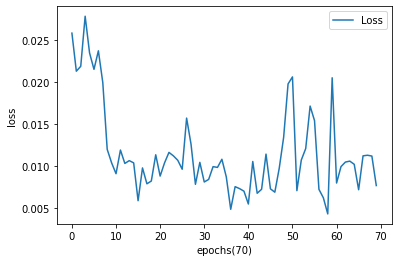

In [ ]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [ ]:

mlp.load_state_dict(grid_scores[highest]['weights'])
mlp.eval()
with torch.no_grad():
  #lr_probs = cnn(X_train.view(-1,1,1,41)).detach().squeeze()
  lr_probs = mlp(X_test).detach().squeeze()
probs = torch.max(lr_probs, dim=1)
idxs, scores = probs.indices, probs.values
probs = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]
preds = torch.argmax(lr_probs, dim=1).cpu()
lr_probs = torch.max(lr_probs, dim=1).values
probs = np.array(probs)

In [ ]:
suspicious = probs[(probs>0.4) & (probs<0.5)].shape[0]

In [ ]:
print(f'{suspicious} packets are suspicious')

237 packets are suspicious


In [ ]:
cm = confusion_matrix(y_test, preds)
tn=cm[1][1] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[0][0] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+"\nRecall: "+str(format(recall,'.4f')))

Test accuracy is:0.8288
Precision: 0.7246
Recall: 0.9722


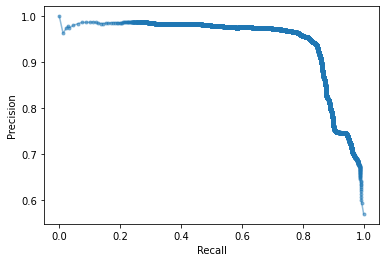

F1:	 82.731%
AUC:	 94.477%
Accuracy:82.882%


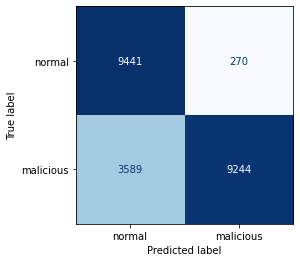

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)
lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==0]) / len(y_test)
acc = accuracy_score(y_test, preds)
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['normal', 'malicious'])
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

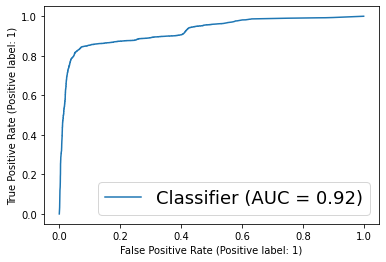

In [ ]:
_ = RocCurveDisplay.from_predictions(y_test,probs)

In [ ]:
wandb.finish()

In [ ]:
torch.save(mlp.state_dict(), 'mlp.pt')